In [ ]:
LEARNING_TYPE = "pointwise"
MODEL_CLASS = "ConvNCF"
DATA_NAME = "movielens"
MODEL_NAME = f"{MODEL_CLASS}_{DATA_NAME}"

In [3]:
WORK_DIR_PATH = "../.."

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')
# WORK_DIR_PATH = "/content/drive/MyDrive/RS-DMF/"

# Constants

In [ ]:
# split
TRN_NEG_PER_POS = 4
TST_NEG_PER_POS = 99
LOO_NEG_PER_POS = TST_NEG_PER_POS
TRN_BATCH_SIZE = 256
TST_BATCH_SIZE = TRN_BATCH_SIZE
LOO_BATCH_SIZE = 1000
TRN_VAL_TST_RATIO = dict(trn=0.8, val=0.1, tst=0.1)
NEG_PER_POS_RATIO = dict(trn=TRN_NEG_PER_POS, val=TRN_NEG_PER_POS, tst=TST_NEG_PER_POS, loo=LOO_NEG_PER_POS)
BATCH_SIZE = dict(trn=TRN_BATCH_SIZE, val=TRN_BATCH_SIZE, tst=TST_BATCH_SIZE, loo=LOO_BATCH_SIZE)
HIST_SELECTOR_TYPE = "tfidf"
MAX_HIST = 400 if HIST_SELECTOR_TYPE=="tfidf" else None
SHUFFLE = True

In [6]:
# Model
N_FACTORS = 32
CHANNELS = 16
DROPOUT = 0.2

In [ ]:
# how to learn
LEARNING_RATE = 1e-4
LAMBDA_ = 1e-6

In [8]:
# how to monitor
METRIC_FN_TYPE = "ndcg"
PATIENCE = 5
MIN_DELTA = 1e-3

In [9]:
# how to loop
N_EPOCHS = 1000
WARM_UP = 10
INTERVAL = 1

# Config

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.chdir(WORK_DIR_PATH)
print(f"DIRECTORY: {os.getcwd()}")

DIRECTORY: c:\Users\jayar\Desktop\바탕 화면\REPO\PAPER REVIEW\RECSYS\07_RS-ConvNCF


In [12]:
import pandas as pd
import torch
from ConvNCF import convncf
import UTILS
from DATA_SPLITTER.trn_val_tst import TRN_VAL_TST
from LOOP.loop import TrainingLoop
from LOOP.monitor.monitor import EarlyStoppingMonitor
from LOOP.predictor.predictor import PerformancePredictor
from LOOP.evaluator.evaluator import PerformanceEvaluator

In [13]:
if LEARNING_TYPE=="listwise":
    from LOOP.trainer.listwise import ListwiseTrainer as Trainer
    TASK_FN_TYPE = "climf"

elif LEARNING_TYPE=="pairwise":
    from LOOP.trainer.pairwise import PairwiseTrainer as Trainer
    TASK_FN_TYPE = "bpr"

elif LEARNING_TYPE=="pointwise":
    from LOOP.trainer.pointwise import PointwiseTrainer as Trainer
    TASK_FN_TYPE = "bce"

else:
    raise ValueError()

In [14]:
from UTILS.constants import (
    DEFAULT_USER_COL,
    DEFAULT_ITEM_COL,
    DEFAULT_RATING_COL,
    DEFAULT_LABEL_COL,
    DEFAULT_TIMESTAMP_COL,
    DEFAULT_PREDICTION_COL,
    COL_DICT,
    DEFAULT_K,
    DEFAULT_THRESHOLD,
    SEED,
)

In [15]:
# seed
UTILS.seed.reset()

SETTING ALL SEEDS TO 42...
ALL SEEDS SET


In [16]:
# Available GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data Preparation

In [17]:
data = pd.read_csv(f"./_data/{DATA_NAME}.csv")

In [18]:
# Number of user, item
N_USERS = data[DEFAULT_USER_COL].nunique()
N_ITEMS = data[DEFAULT_ITEM_COL].nunique()

In [19]:
# data Description
UTILS.datahandler.description(data)

number of user: 610
number of item: 9724
total interaction: 100836
interaction density: 1.7000 %
max interaction of user: 2698
max interaction of item: 329
top 10.0 % interaction of user: 400.3
top 10.0 % interaction of item: 27.0
mean interaction of user: 165
mean interaction of item: 10


In [ ]:
kwargs = dict(
    n_users=N_USERS,
    n_items=N_ITEMS,
    learning_type=LEARNING_TYPE,
)

dataloader = TRN_VAL_TST(**kwargs)

In [21]:
kwargs = dict(
    origin=data,
    trn_val_tst_ratio=TRN_VAL_TST_RATIO,
    neg_per_pos_ratio=NEG_PER_POS_RATIO,
    batch_size=BATCH_SIZE,
    hist_selector_type=HIST_SELECTOR_TYPE,
    max_hist=MAX_HIST,
    shuffle=SHUFFLE,
)

loaders, interactions, (user_hist, item_hist) = dataloader.get(**kwargs)

In [22]:
trn_loader, val_loader, tst_loader, loo_loader = loaders

# Modeling

In [23]:
kwargs = dict(
    n_users=N_USERS,
    n_items=N_ITEMS,
    n_factors=N_FACTORS,
    dropout=DROPOUT,
    channels=CHANNELS,
)

model = convncf.model.Module(**kwargs)

In [24]:
kwargs = dict(
    model=model,
    task_fn_type=TASK_FN_TYPE,
    lr=LEARNING_RATE,
    lambda_=LAMBDA_
)

trainer = Trainer(**kwargs)

In [25]:
kwargs = dict(
    model=model,
    metric_fn_type=METRIC_FN_TYPE,
    patience=PATIENCE,
    min_delta=MIN_DELTA,
)

monitor = EarlyStoppingMonitor(**kwargs)

In [26]:
kwargs = dict(
    model=model,
    trainer=trainer,
    monitor=monitor,
)

loop = TrainingLoop(**kwargs)

# Train

In [27]:
kwargs = dict(
    trn_loader=trn_loader,
    val_loader=val_loader,
    loo_loader=loo_loader,
    n_epochs=N_EPOCHS,
    warm_up=WARM_UP,
    interval=INTERVAL,
)

history = loop.fit(**kwargs)

LEAVE ONE OUT
	BEST SCORE: 0.4733
	BEST EPOCH: 11
COMPUTING COST FOR LEARNING
	(s/epoch): 0.1795
	(epoch/s): 5.5724
	(s/batch): 0.0067
	(batch/s): 148.4419


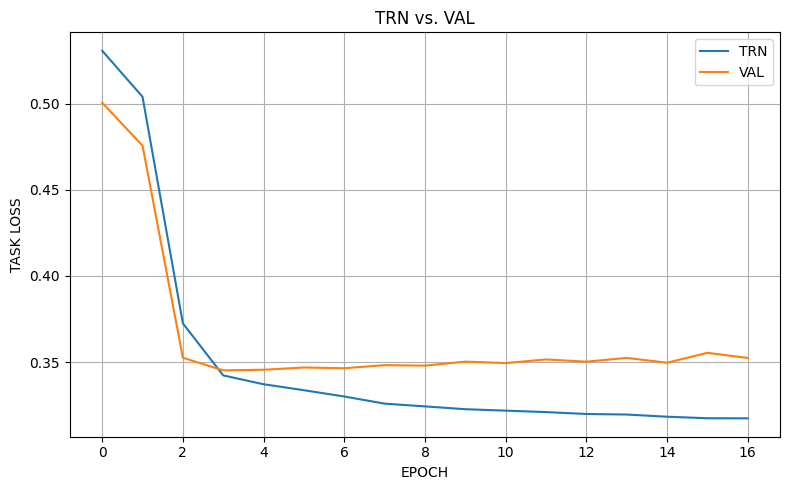

In [28]:
UTILS.visualizer.loss_plot(history, 'TASK LOSS')

# Test

In [29]:
predictor = PerformancePredictor(model)

In [30]:
result = predictor.predict(tst_loader)

COMPUTING COST FOR INFERENCE
	(s/epoch): 3.5897
	(epoch/s): 0.2786
	(s/batch): 0.0009
	(batch/s): 1090.8998


In [31]:
evaluator = PerformanceEvaluator()

In [32]:
eval = evaluator.evaluate(result)
eval

,top_k,hit_ratio,precision,recall,map,ndcg
0,5,0.745902,0.268197,0.207143,0.141636,0.326625
1,10,0.867213,0.212131,0.311925,0.174220,0.340162
2,15,0.914754,0.180546,0.377947,0.189291,0.355076
3,20,0.949180,0.159344,0.430709,0.198738,0.368477
4,25,0.963934,0.143607,0.470445,0.205245,0.378848
5,50,0.996721,0.100393,0.597004,0.221227,0.415580
6,100,1.000000,0.068475,0.721492,0.233142,0.457131


# Save

In [33]:
PATH = f'./_checkpoints/{LEARNING_TYPE}/{MODEL_NAME}.pth'

kwargs = dict(
    model=model,
    path=PATH,
)

UTILS.checkpointer.save(**kwargs)